In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cityscapes-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5848669%2F9589700%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T153315Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d08f3c90222eb1eabffade86534dda5b2a4387068954739b4c4f11bb2785959114e60c57724527aae5672830f8d0046c739e15abd6467109a00afd9c299b6b91e8db7186677ba7edfaf717fbfd5367f295d6c49a26bb5717191052a29eb0b8cb658ebe0f0848f0204744f8d9f9a532342f2a004f748c8a8a4bd7f410219f0002203ef4d681ea845ad71c04c13f180233279899d8b03412cb051cf40bc2f8e68cabaa6f0f27638c7598ac435ee92a2b2198b678b94a71a83f190349897841b83ae6c3330d40e62480b1566226bfcd7aef8d9c0da90ce86c3def0ffd05b01272bedb55fa9827b13105314e87cd5240163c56d36f3424616781d4493fe057a7292'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7009393277 bytes downloaded
Downloaded and uncompressed: cityscapes-segmentation
Data source import complete.


In [ ]:
from collections import namedtuple

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
# Label = namedtuple( 'Label' , [

#     'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
#                     # We use them to uniquely name a class

#     'id'          , # An integer ID that is associated with this label.
#                     # The IDs are used to represent the label in ground truth images
#                     # An ID of -1 means that this label does not have an ID and thus
#                     # is ignored when creating ground truth images (e.g. license plate).

#     'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
#                     # images for training.
#                     # For training, multiple labels might have the same ID. Then, these labels
#                     # are mapped to the same class in the ground truth images. For the inverse
#                     # mapping, we use the label that is defined first in the list below.
#                     # For example, mapping all void-type classes to the same ID in training,
#                     # might make sense for some approaches.

#     'category'    , # The name of the category that this label belongs to

#     'categoryId'  , # The ID of this category. Used to create ground truth images
#                     # on category level.

#     'hasInstances', # Whether this label distinguishes between single instances or not

#     'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
#                     # during evaluations or not

#     'color'       , # The color of this label in greyscale
#     ] )


# #--------------------------------------------------------------------------------
# # A list of all labels
# #--------------------------------------------------------------------------------

# # Please adapt the train IDs as appropriate for you approach.
# # Note that you might want to ignore labels with ID 255 during training.
# # Make sure to provide your results using the original IDs and not the training IDs.
# # Note that many IDs are ignored in evaluation and thus you never need to predict these!

# labels = [
#     #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
#     Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
#     Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
#     Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
#     Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
#     Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
#     Label(  'parking'              ,  9 ,      20 , 'ground'          , 1       , False        , True         , (250,170,160) ),
#     Label(  'rail track'           , 10 ,      20 , 'ground'          , 1       , False        , True         , (230,150,140) ),
#     Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
#     Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
#     Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
#     Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True         , (180,165,180) ),
#     Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True         , (150,100,100) ),
#     Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
#     Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
#     Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True         , (153,153,153) ),
#     Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
#     Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
#     Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
#     Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
#     Label(  'sky'                  , 23 ,       20 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
#     Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
#     Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
#     Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
#     Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
#     Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
#     Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
#     Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
#     Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
#     Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
#     Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
#     Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
# ]

In [ ]:
image_dir = '/kaggle/input/cityscapes-segmentation/images/train'
label_dir = '/kaggle/input/cityscapes-segmentation/labels/train'

print("Images Directory:", os.listdir(image_dir))

print("Labels Directory:", os.listdir(label_dir))

Images Directory: ['erfurt', 'dusseldorf', 'stuttgart', 'ulm', 'jena', 'hamburg', 'hanover', 'weimar', 'zurich', 'krefeld', 'bochum', 'aachen', 'monchengladbach', 'darmstadt', 'strasbourg', 'bremen', 'cologne', 'tubingen']
Labels Directory: ['erfurt', 'dusseldorf', 'stuttgart', 'ulm', 'jena', 'hamburg', 'hanover', 'weimar', 'zurich', 'krefeld', 'bochum', 'aachen', 'monchengladbach', 'darmstadt', 'strasbourg', 'bremen', 'cologne', 'tubingen']


In [ ]:

# Function to generate file paths for train dataset
def get_train_file_paths(images_dir, labels_dir):
    data = []
    # Iterate through cities in the train images folder
    for city in os.listdir(images_dir):
        city_image_dir = os.path.join(images_dir, city)
        city_label_dir = os.path.join(labels_dir, city)
        if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):
            for file in os.listdir(city_image_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_image_dir, file)
                    image_name = file.replace('_leftImg8bit.png', '')
                    image_label_path = os.path.join(city_label_dir, f'{image_name}_gtFine_labelTrainIds.png')
                    image_polygons_path = os.path.join(city_label_dir, f'{image_name}_gtFine_polygons.json')
                    data.append([image_path, image_label_path, image_polygons_path])
    return pd.DataFrame(data, columns=['image_path', 'image_label_path', 'image_polygons_path'])

# Function to generate file paths for test dataset
def get_test_file_paths(test_dir):
    data = []
    # Iterate through cities in the test images folder
    for city in os.listdir(test_dir):
        city_dir = os.path.join(test_dir, city)
        if os.path.isdir(city_dir):
            for file in os.listdir(city_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_dir, file)
                    data.append([image_path])
    return pd.DataFrame(data, columns=['image_path'])

# Paths to images and labels directories
images_dir_train = '/kaggle/input/cityscapes-segmentation/images/train'
labels_dir_train = '/kaggle/input/cityscapes-segmentation/labels/train'
images_dir_test = '/kaggle/input/cityscapes-segmentation/images/test'

# Create train and test DataFrames
train_df = get_train_file_paths(images_dir_train, labels_dir_train)
test_df = get_test_file_paths(images_dir_test)

In [ ]:
#TODO : Split the dataset into training and validation data
#TODO : Save the split to csv file

In [ ]:
print("Number of Samples before Split: ", len(train_df))

# Shuffle the DataFrame
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Calculate the number of samples for the validation set
val_size = 380

# Split the DataFrame into train and validation sets
train_df_final = train_df[:-val_size]
val_df_final = train_df[-val_size:]

print("Train Samples (After Split): ", len(train_df_final))
print("Val Samples (After Split): ", len(val_df_final))

#TODO : Save the split to csv file
train_df_final.to_csv("train_data.csv", index=False)
val_df_final.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

Number of Samples before Split:  2380
Train Samples (After Split):  2000
Val Samples (After Split):  380


In [ ]:
#PRINT SAMPLE FROM CSV_FILE

In [ ]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

,image_path,image_label_path,image_polygons_path
0,/kaggle/input/cityscapes-segmentation/images/t...,/kaggle/input/cityscapes-segmentation/labels/t...,/kaggle/input/cityscapes-segmentation/labels/t...
1,/kaggle/input/cityscapes-segmentation/images/t...,/kaggle/input/cityscapes-segmentation/labels/t...,/kaggle/input/cityscapes-segmentation/labels/t...
2,/kaggle/input/cityscapes-segmentation/images/t...,/kaggle/input/cityscapes-segmentation/labels/t...,/kaggle/input/cityscapes-segmentation/labels/t...
3,/kaggle/input/cityscapes-segmentation/images/t...,/kaggle/input/cityscapes-segmentation/labels/t...,/kaggle/input/cityscapes-segmentation/labels/t...
4,/kaggle/input/cityscapes-segmentation/images/t...,/kaggle/input/cityscapes-segmentation/labels/t...,/kaggle/input/cityscapes-segmentation/labels/t...


In [ ]:
#TODO: write your own data analysis techniques

In [ ]:
# # Define the LoadImage transformation
# class LoadImage:
#     def __init__(self, keys):
#         self.keys = keys

#     def __call__(self, sample):
#         for key in self.keys:
#             sample[key] = cv2.imread(sample[key])
#         return sample

In [ ]:
# Define the LoadImage transformation
class LoadImage:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        for key in self.keys:
            sample[key] = cv2.imread(sample[key])
        return sample

In [ ]:
id_mapping = {
    0: 20,  # unlabeled
    1: 20,  # ego vehicle
    2: 20,  # rectification border
    3: 20,  # out of roi
    4: 20,  # static
    5: 20,  # dynamic
    6: 20,  # ground
    7: 0,   # road
    8: 1,   # sidewalk
    9: 20,  # parking
    10: 20, # rail track
    11: 2,  # building
    12: 3,  # wall
    13: 4,  # fence
    14: 20, # guard rail
    15: 20, # bridge
    16: 20, # tunnel
    17: 5,  # pole
    18: 20, # polegroup
    19: 6,  # traffic light
    20: 7,  # traffic sign
    21: 8,  # vegetation
    22: 9,  # terrain
    23: 20, # sky
    24: 11, # person
    25: 12, # rider
    26: 13, # car
    27: 14, # truck
    28: 15, # bus
    29: 20, # caravan
    30: 20, # trailer
    31: 16, # train
    32: 17, # motorcycle
    33: 18, # bicycle
    34: 19  # license plate
}

In [ ]:
#TODO : TRAIN DATA PREPROCESSING PIPELINE
#Train_data_transform=Compose([
#    LoadImage( keys= ['image','mask'] ),

    #Write your own data transforms and augmentations

#])

In [ ]:
# One-Hot-encoding




In [ ]:
# Define the Normalize transformation
class Normalize:
    def __call__(self, sample):
        sample['image'] = sample['image'] / 255.0  # Normalize to [0, 1]
        return sample

In [ ]:
class ContrastMask:
    def __init__(self, keys):
        self.keys = keys

    def enhance_contrast(self, mask):
        # Convert to float to avoid clipping during operations
        mask_float = mask.astype(np.float32)
        # Apply histogram equalization
        mask_equalized = cv2.equalizeHist(mask_float.astype(np.uint8))
        return mask_equalized

    def __call__(self, sample):
        for key in self.keys:
            if key == 'mask':
                # Convert mask to grayscale if it's not already
                if len(sample[key].shape) == 3:
                    sample[key] = cv2.cvtColor(sample[key], cv2.COLOR_BGR2GRAY)
                sample[key] = self.enhance_contrast(sample[key])
        return sample



In [ ]:
# # colored mask
# mask_colored = cv2.applyColorMap(mask_enhanced, cv2.COLORMAP_JET)

# # Visualize the colored mask
# plt.figure(figsize=(6, 6))
# plt.title('Colored Enhanced Mask')
# plt.imshow(mask_colored)
# plt.axis('off')
# plt.show()

In [ ]:
# Define the Resize transformation
class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        for key in sample.keys():
            sample[key] = cv2.resize(sample[key], self.size)
        return sample

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [ ]:
# Define the training data transform pipeline
Train_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Normalize(),
    ContrastMask(keys=['mask']),
    Resize(size=(256, 256))
])

In [ ]:
# Preprocess training data
def preprocess_data(df):
    processed_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path'], 'mask': row['image_label_path']}
        transformed_sample = Train_data_transform(sample)
        processed_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_data

In [ ]:
# Preprocess training data
processed_data = preprocess_data(train_df_final)
print(f"Processed Images: {len(processed_data)}")


Processed Images: 2000


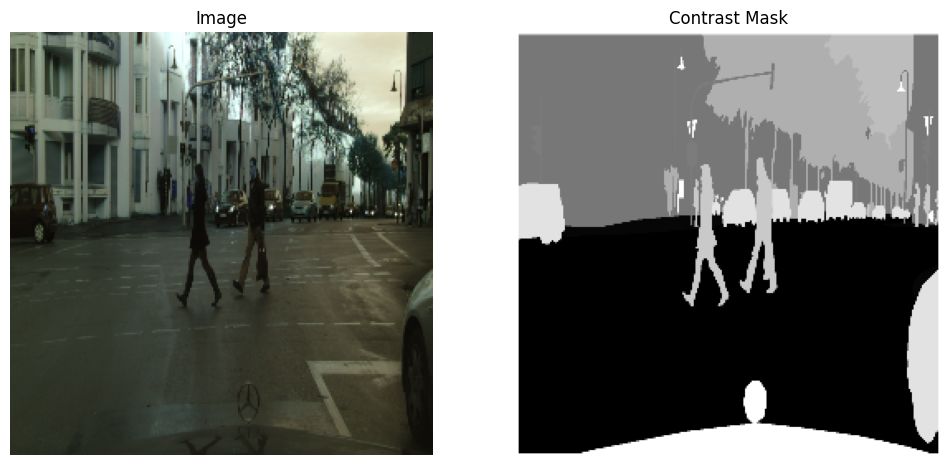

In [ ]:
# visualize a sample
def visualize_sample(processed_sample):
    image, mask = processed_sample
    # Convert image from [0, 1] to [0, 255] for display
    image = (image * 255).astype(np.uint8)

    # Create a figure to show image and mask
    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Contrast Mask')
    plt.axis('off')

    plt.show()

visualize_sample(processed_data[1000])

In [ ]:
#TODO : VALIDATION DATA PREPROCESSING PIPELINE


#Valid_data_transform=Compose([
#    LoadImage(['image','mask']),

    #Write your own data transforms and augmentations

#])

In [ ]:
Val_data_transform = Compose([
    LoadImage(keys=['image', 'mask']),
    Resize(size=(256, 256)),
    Normalize(),
    ContrastMask(keys='mask'),
])

In [ ]:
# Preprocess val data
def preprocess_val_data(df):
    processed_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path'], 'mask': row['image_label_path']}
        transformed_sample = Val_data_transform(sample)
        processed_data.append((transformed_sample['image'], transformed_sample['mask']))
    return processed_data

In [ ]:
# Preprocess validation data
processed_val_data = preprocess_data(val_df_final)
# Example output to verify shapes
print(f"Processed Images: {len(processed_val_data)}")

Processed Images: 380


In [ ]:
#TODO : TEST DATA PREPROCESSING PIPELINE


#Test_data_transform=Compose([
#    LoadImage(['image','mask']),

    #Write your own data transforms and augmentations

#])

In [ ]:
test_data_transform = Compose([
    LoadImage(keys=['image']),
    Resize(size=(256, 256)),
])

In [ ]:
# Preprocess training data
def preprocess_test_data(df):
    processed_data = []
    for index, row in df.iterrows():
        sample = {'image': row['image_path']}
        transformed_sample = test_data_transform(sample)
        processed_data.append((transformed_sample['image']))
    return processed_data

In [ ]:
# Preprocess validation data
processed_test_data = preprocess_test_data(test_df)
# Example output to verify shapes
print(f"Processed Images: {len(processed_test_data)}")

Processed Images: 595


In [ ]:
import re
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from typing import List
from torchvision.transforms import Compose


class Dataset(Dataset):
    def __init__(self, input_dataframe: pd.DataFrame, KeysOfInterest: List[str], data_transform:Compose): # TODO: add parameters if needed
        self.koi = KeysOfInterest
        self.input_dataframe = input_dataframe[self.koi]
        self.data_transform=data_transform

    def __getitem__(self, item: int):
        pass
        #TODO : write this function

    def __len__(self):
        return len(self.input_dataframe)

In [ ]:
#TODO : Initilize your datasets

#ds_train=Dataset(input_dataframe=csv_train,
#                 root_dir="",
#                 KeysOfInterest=["",""],
#                 data_transform=train_data_transform)


In [ ]:
#dl_train=DataLoader(dataset=ds_train,batch_size= 2 ,num_workers=8 ,prefetch_factor=8,shuffle=True)

In [ ]:
#TODO : Show samples from your data loaders

In [ ]:
#TODO : Write the model you are going to use (Pytorch)

In [ ]:
#TODO : Write the loss function you are going to use

In [ ]:
#TODO : Write the evaluation metrics you are going to use

In [ ]:
#TODO : Write your own Training loop using pytorch

In [ ]:
#TODO : Plot losses and metrics graphs

In [ ]:
#TODO : Test your model and show some samples